# GenAI with Python: AI Agents from Zero to Hero

###### Read on TDS: [Article (Part 1)](https://towardsdatascience.com/ai-agents-from-zero-to-hero-part-1/) ,  [Article (Part 2)](https://towardsdatascience.com/ai-agents-from-zero-to-hero-part-2/) ,  [Article (Part 3)](https://towardsdatascience.com/ai-agents-from-zero-to-hero-part-3/)

## 0 - Setup

In [1]:
#pip install ollama==0.4.7
import ollama
llm = "qwen2.5"

In [68]:
stream = ollama.generate(model=llm, prompt='''what time is it?''', stream=True)
for chunk in stream:
    print(chunk['response'], end='', flush=True)

To provide you with the current time, I would need to know your location or timezone since "time" can refer to different times in different parts of the world. Could you please tell me which timezone you're interested in? If you just want a general idea, you can check your device's clock for the current time.

## ------------------------------------------
## 1 - Single Agent
## ------------------------------------------

### 1.1. Simple (WebSearch)

In [3]:
#pip install langchain-community==0.3.17
#pip install duckduckgo_search==6.3.5
from langchain_community.tools import DuckDuckGoSearchResults 

def search_web(query:str) -> str:
  return DuckDuckGoSearchResults(backend="news").run(query)

tool_search_web = {'type':'function', 'function':{
  'name': 'search_web',
  'description': 'Search the web',
  'parameters': {'type': 'object', 
                 'required': ['query'],
                 'properties': {
                    'query': {'type':'str', 'description':'the topic or subject to search on the web'},
}}}}
## test
search_web(query="nvidia")

"snippet: Trump officials are probing whether China's DeepSeek bought advanced Nvidia semiconductors through third parties in Singapore., title: Singapore buys only small amount of Nvidia chips, official says, link: https://www.msn.com/en-us/money/other/singapore-buys-only-small-amount-of-nvidia-chips-official-says/ar-AA1zgsRV, date: 2025-02-18T11:43:00+00:00, source: Bloomberg on MSN.com, snippet: Nvidia's stock took a major hit last month with the debut of Chinese AI chatbot DeepSeek. Its makers claimed it could do the work of American chatbots but for a much smaller price, title: Nvidia shocks investors, buys and sells popular AI stocks, link: https://www.msn.com/en-us/money/companies/nvidia-shocks-investors-buys-and-sells-popular-ai-stocks/ar-AA1zdSYr, date: 2025-02-17T16:07:00+00:00, source: TheStreet on MSN.com, snippet: Nvidia (NVDA 2.63%) shares have advanced 180% since January 2024 amid incredible demand for its artificial intelligence platforms. But billionaire Israel England

In [4]:
def search_yf(query:str) -> str:
  return DuckDuckGoSearchResults(backend="news").run(f"site:finance.yahoo.com {query}")

tool_search_yf = {'type':'function', 'function':{
  'name': 'search_yf',
  'description': 'Search for specific financial news',
  'parameters': {'type': 'object', 
                 'required': ['query'],
                 'properties': {
                    'query': {'type':'str', 'description':'the financial topic or subject to search'},
}}}}
## test
search_yf(query="nvidia")

'snippet: We recently compiled a list of the Jim Cramer Discusses These 11 Stocks & Finds Few Reasons To Sell. In this article, we are going to take a look at where NVIDIA Corporation (NASDAQ:NVDA) stands against the other stocks., title: Jim Cramer on NVIDIA (NVDA): \'I Think You Have To Wait To See What The Numbers Are Because The Company\'s In Quiet Period\', link: https://finance.yahoo.com/news/jim-cramer-nvidia-nvda-think-115144647.html, date: 2025-02-18T11:51:00+00:00, source: YAHOO!Finance, snippet: To be specific, Meta is preparing to spend up to $65 billion in AI infrastructure this year -- representing a 65% increase year over year. Given the company works closely with Nvi, title: Did Meta Platforms Just Say "Checkmate" to Nvidia?, link: https://finance.yahoo.com/news/did-meta-platforms-just-checkmate-120000327.html, date: 2025-02-18T12:00:00+00:00, source: YAHOO!Finance, snippet: Nvidia (NASDAQ: NVDA) shares have advanced 180% since January 2024 amid incredible demand for it

In [19]:
prompt = '''You are an assistant with access to tools, you must decide when to use tools to answer user message.''' 
messages = [{"role":"system", "content":prompt}]

while True:
    ## user input
    try:
        q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    messages.append( {"role":"user", "content":q} )
    
    ## model
    agent_res = ollama.chat(
        model=llm,
        #format="json", #or schema
        stream=False,
        tools=[tool_search_web, tool_search_yf],
        messages=messages)
  
    ## response
    dic_tools = {'search_web':search_web, 'search_yf':search_yf}

    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                messages.append( {"role":"user", "content":"use tool '"+t_name+"' with inputs: "+str(t_inputs)} )
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                print(t_output)
                ### final res
                p = f'''Summarize this to answer user question, be as concise as possible: {t_output}'''
                res = ollama.generate(model=llm, prompt=q+". "+p)["response"]
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
  
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
      
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )

🙂 > hi


👽 > Hello! How can I assist you today?


🙂 > tell me about Powell


🔧 > search_web -> Inputs: {'query': 'Powell'}
snippet: Norman Powell scored a season-high 41 points and James Harden added 32 to lift the Los Angeles Clippers to a 120-116 overtime victory over the Utah Jazz on Thursday night. Harden also had 10 rebounds,, title: Powell scores 41 points, Harden has 32 to rally Clippers to 120-116 OT victory over Jazz, link: https://www.msn.com/en-us/sports/other/powell-scores-41-points-harden-has-32-to-rally-clippers-to-120-116-ot-victory-over-jazz/ar-AA1z1Avi, date: 2025-02-14T05:07:00+00:00, source: MSN, snippet: Federal Reserve Chair Jerome Powell said the latest consumer price data show that while the central bank has made substantial progress toward taming inflation, there is still more work to do., title: Powell Says New Inflation Data Show Fed Has More Work to Do, link: https://www.bloomberg.com/news/articles/2025-02-12/powell-says-latest-inflation-data-show-fed-has-more-work-to-do, date: 2025-02-12T16:26:00+00:00, source: Bloomberg L.P., snippe

🙂 > be more specific about the rate cut


🔧 > search_yf -> Inputs: {'query': 'Jerome Powell rate cut'}
snippet: Federal Reserve Chair Jerome Powell will tell the Senate banking committee the Fed isn't "in a hurry" to resume its interest rate cutting campaign., title: Powell says Fed not 'in a hurry' to cut interest rates with 'economy remaining strong', link: https://finance.yahoo.com/news/powell-says-fed-not-hurry-150310004.html, date: 2025-02-11T15:03:00+00:00, source: YAHOO!Finance, snippet: Treasuries fell as traders anticipate that Federal Reserve Chair Jerome Powell will reiterate that US interest rates are on hold in congressional testimony Tuesday. Most Read from BloombergSaudi Arabia's Neom Signs $5 Billion Deal for AI Data CenterNice Airport,, title: Treasuries Fall as Fed's Powell Affirms Patience on Rate Cuts, link: https://finance.yahoo.com/news/treasuries-slip-tariffs-dominating-powell-111714559.html, date: 2025-02-11T14:18:00+00:00, source: YAHOO!Finance, snippet: Just before the release of Wednesday's monthly c

🙂 > quit


In [20]:
messages

[{'role': 'system',
  'content': 'You are an assistant with access to tools, you must decide when to use tools to answer user message.'},
 {'role': 'user', 'content': 'hi'},
 {'role': 'assistant', 'content': 'Hello! How can I assist you today?'},
 {'role': 'user', 'content': 'tell me about Powell'},
 {'role': 'assistant',
  'content': "The snippets provide information about Jerome Powell's statements and actions in February 2025:\n\n1. Norman Powell scored 41 points, James Harden added 32, helping the Los Angeles Clippers defeat the Utah Jazz in overtime.\n\n2. Jerome Powell stated that while significant progress has been made in taming inflation, more work is needed based on recent consumer price data.\n\n3. Powell testified before a Senate committee about monetary policy and denied any attempts by Elon Musk or his team to access Fed systems.\n\n4. Higher inflation readings led to Powell informing lawmakers, business executives, and the public that they might need to wait longer for r

In [21]:
agent_res

{'model': 'qwen2.5',
 'created_at': '2025-02-14T12:56:42.282608Z',
 'message': {'role': 'assistant',
  'content': '',
  'tool_calls': [{'function': {'name': 'search_yf',
     'arguments': {'query': 'Jerome Powell rate cut'}}}]},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 47726659663,
 'load_duration': 30518855,
 'prompt_eval_count': 525,
 'prompt_eval_duration': 39558000000,
 'eval_count': 59,
 'eval_duration': 8102000000}

### 1.2. Advanced (Coding)

###### What I want

In [6]:
import pandas as pd

dtf = pd.read_csv('http://bit.ly/kaggletrain')
dtf.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


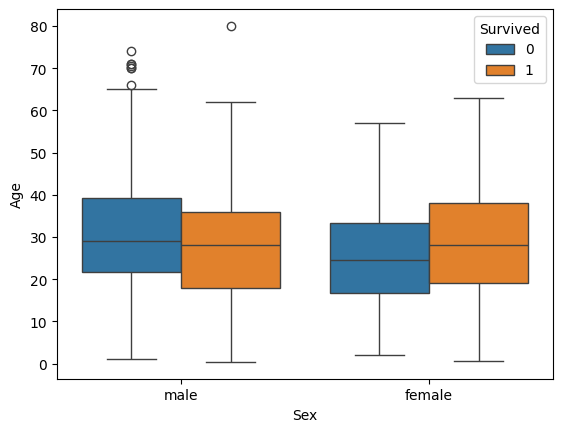

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=dtf, x="Sex", y="Age", hue="Survived")
plt.show()

###### Model

In [75]:
import io
import contextlib

def code_exec(code:str) -> str:
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        try:
            exec(code)
        except Exception as e:
            print(f"Error: {e}")
    return output.getvalue()

tool_code_exec = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'execute python code',
  'parameters': {'type': 'object', 
                 'required': ['code'],
                 'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

code_exec("a=1+1; print(a)")

'2\n'

📁 Provide a CSV path > http://bit.ly/kaggletrain


🔧 > code_exec -> Inputs: {'code': 'import pandas as pd; df=pd.read_csv("http://bit.ly/kaggletrain"); print(df.head())'}
👽 >    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250  

🙂 > create a boxplot with the columns 'Sex' and 'Age' and use the column 'Survived' for color


🔧 > code_exec -> Inputs: {'code': 'import matplotlib.pyplot as plt; import seaborn as sns; import pandas as pd; df = pd.read_csv("http://bit.ly/kaggletrain"); sns.boxplot(x=df[\'Sex\'], y=df[\'Age\'], hue=df[\'Survived\']); plt.show()'}


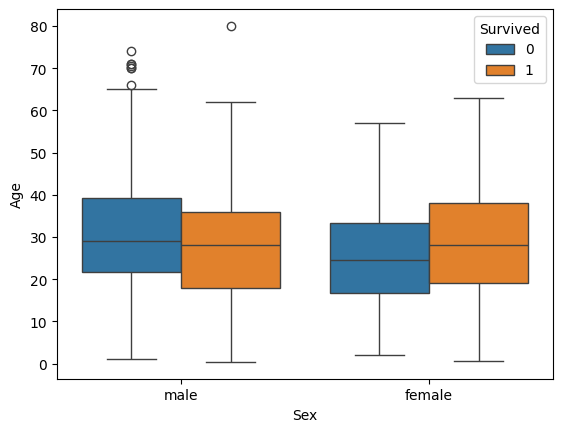

👽 > 


🙂 > quit


In [68]:
prompt = '''You are an expert data scientist, and you have tools to execute python code.
First of all, execute the following code exactly as it is: 'df=pd.read_csv(path); print(df.head())'
If you create a plot, ALWAYS add 'plt.show()' at the end.
'''
messages = [{"role":"system", "content":prompt}]
memory = '''Use the dataframe 'df'.'''
start = True

while True:
    ## user input
    try:
        if start is True:
            path = input('📁 Provide a CSV path >')
            q = "path = "+path
        else:
            q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    
    ## memory
    if start is False:
        q = memory+"\n"+q
    messages.append( {"role":"user", "content":q} )

    ## model
    agent_res = ollama.chat(
        model=llm,
        #format="json", #or schema
        stream=False,
        tools=[tool_code_exec],
        messages=messages)
  
    ## response
    dic_tools = {'code_exec':code_exec}
    
    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                messages.append( {"role":"user", "content":"use tool '"+t_name+"' with inputs: "+str(t_inputs)} )
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
  
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
      
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )
    start = False

In [69]:
messages

[{'role': 'system',
  'content': "You are an expert data scientist, and you have tools to write and execute python code.\nFirst of all, use the tool to execute the following code exactly like this: 'df=pd.read_csv(path); print(df.head())'\nRight after you use the tool to generate code, you MUST ALWAYS use also the tool to execute the code you generated.\n"},
 {'role': 'user', 'content': 'path = http://bit.ly/kaggletrain'},
 {'role': 'user',
  'content': 'use tool \'code_exec\' with inputs: {\'code\': \'import pandas as pd; df=pd.read_csv("http://bit.ly/kaggletrain"); print(df.head())\'}'},
 {'role': 'assistant',
  'content': '   PassengerId  Survived  Pclass  \\\n0            1         0       3   \n1            2         1       1   \n2            3         1       3   \n3            4         1       1   \n4            5         0       3   \n\n                                                Name     Sex   Age  SibSp  \\\n0                            Braund, Mr. Owen Harris    male  

## ------------------------------------------
## 2 - Iterations & Chains
## ------------------------------------------

### 2.1. Iteration

In [21]:
import yfinance as yf

stock = "MSFT"
yf.Ticker(ticker=stock).history(period='5d') #1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-17 00:00:00-04:00,386.700012,392.709991,385.570007,388.700012,22474300,0.0,0.0
2025-03-18 00:00:00-04:00,387.070007,387.369995,381.100006,383.519989,19486900,0.0,0.0
2025-03-19 00:00:00-04:00,385.529999,389.679993,384.000000,387.820007,19185500,0.0,0.0
2025-03-20 00:00:00-04:00,385.739990,391.790009,383.279999,386.839996,18470500,0.0,0.0
2025-03-21 00:00:00-04:00,383.220001,391.739990,382.799988,391.260010,39571500,0.0,0.0


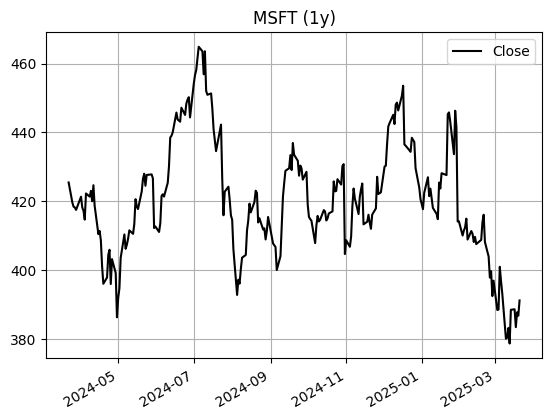

'ok'

In [33]:
import matplotlib.pyplot as plt

def get_stock(ticker:str, period:str, col:str):
    data = yf.Ticker(ticker=ticker).history(period=period)
    if len(data) > 0:
        data[col].plot(color="black", legend=True, xlabel='', title=f"{ticker.upper()} ({period})").grid()
        plt.show()
        return 'ok'
    else:
        return 'no'

tool_get_stock = {'type':'function', 'function':{
  'name': 'get_stock',
  'description': 'Download stock data',
  'parameters': {'type': 'object',
                 'required': ['ticker','period','col'],
                 'properties': {
                    'ticker': {'type':'str', 'description':'the ticker symbol of the stock.'},
                    'period': {'type':'str', 'description':"for 1 month input '1mo', for 6 months input '6mo', for 1 year input '1y'. Use '1y' if not specified."},
                    'col': {'type':'str', 'description':"one of 'Open','High','Low','Close','Volume'. Use 'Close' if not specified."},
}}}}
## test
get_stock(ticker="msft", period="1y", col="Close")

In [91]:
def use_tool(agent_res:dict, dic_tools:dict) -> dict:
    ## use tool
    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                print(t_output)
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
    ## don't use tool
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
        t_name, t_inputs = '', ''
    return {'res':res, 'tool_used':t_name, 'inputs_used':t_inputs}

🙂 > hi


👽 > Hello! How can I assist you with your finances today? Are you interested in checking the stock prices or analyzing some financial data?


🙂 > show me the last 6 months of microsoft


🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '6mo', 'ticker': 'MSFT'}


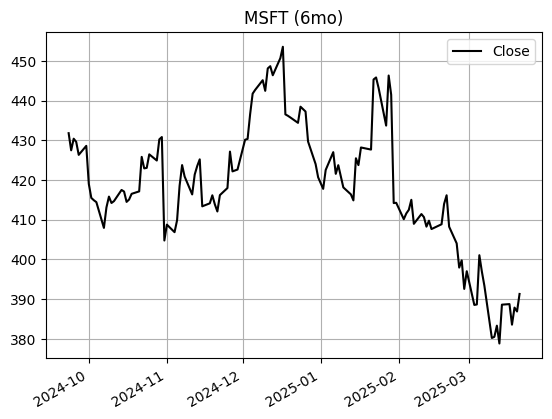

ok
👽 > ok


🙂 > now show me 1 year of facebook stock


🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '1y', 'ticker': 'FB'}


$FB: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


no
🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '6mo', 'ticker': 'FB'}


$FB: possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")


no
🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '1y', 'ticker': 'FB'}


$FB: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


no
🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '1y', 'ticker': 'FB'}


$FB: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


no
👽 > I tried 3 times but something is wrong


🙂 > try with ticker META


🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '1y', 'ticker': 'META'}


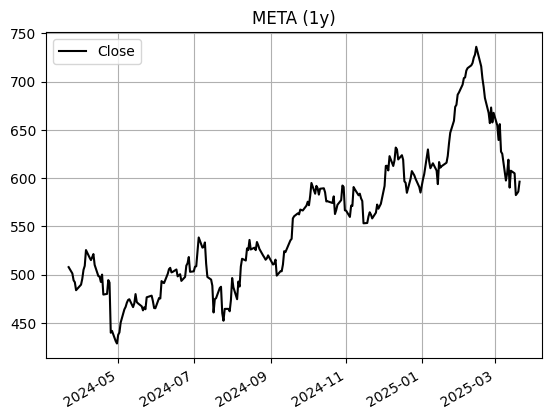

ok
👽 > ok


🙂 > quit


In [45]:
prompt = '''You are a financial analyst, assist the user using your available tools.''' 
messages = [{"role":"system", "content":prompt}]
dic_tools = {'get_stock':get_stock}
max_i, i = 3, 0

while True:
    ## user input
    try:
        q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    messages.append( {"role":"user", "content":q} )
    
    ## model
    agent_res = ollama.chat(model=llm, messages=messages, 
                            tools=[tool_get_stock])
    try:
        dic_res = use_tool(agent_res, dic_tools)
        
    ## handle error: tool not used --> try again
    except Exception as e:
        print("⚠️ >", e)
        agent_res = ollama.chat(model=llm, messages=messages, 
                                tools=[tool_get_stock])
        dic_res = use_tool(agent_res, dic_tools)

    res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
    
    ## handle error: tool used but output not good --> keep trying for x times
    while res == 'no' and i < max_i:
        comment = f'''I used tool '{tool_used}' with inputs {inputs_used}. But it didn't work, so I must try again with different inputs'''
        messages.append( {"role":"assistant", "content":comment} )
        agent_res = ollama.chat(model=llm, messages=messages,
                                tools=[tool_get_stock])
        dic_res = use_tool(agent_res, dic_tools)
        res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
        
        i += 1
        if i == max_i:
            res = f'I tried {i} times but something is wrong'

    ## final response
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )

### 2.2. Chain

In [60]:
search_web(query="facebook stock")

"snippet: Meta (NASDAQ: META) has revitalized Facebook's appeal through Facebook Marketplace, which has attracted younger users looking for a low-cost buying and selling platform. Marketplace positions Meta as a competitor to eBay (NASDAQ: EBAY) by leveraging its massive user base to create an additional revenue stream beyond, title: Facebook Stock (META) Has Gotten a Little Sexy Again, and Instagram Has Nothing to Do With It, link: https://www.msn.com/en-us/money/personalfinance/facebook-stock-meta-has-gotten-a-little-sexy-again-and-instagram-has-nothing-to-do-with-it/ar-AA1B5zql, date: 2025-03-17T14:59:50+00:00, source: 24/7 Wall St., snippet: A BofA Securities analyst says he sees parallels of Alphabet's Google and Meta Platforms in AppLovin's strategies., title: AppLovin Stock Has Hints of Google and Facebook, Says a Bull, link: https://www.msn.com/en-us/technology/tech-companies/applovin-stock-has-hints-of-google-and-facebook-says-a-bull/ar-AA1AMoFL, date: 2025-03-12T16:05:00+00:0

In [70]:
prompt = '''
[GOAL] You are a financial analyst, assist the user using your available tools.

[RETURN] You must return the stock data that the user asks for.

[WARNINGS] In order to retrieve stock data, you need to know the ticker symbol of the company.

[CONTEXT] First ALWAYS try to use the tool 'get_stock'.
If it doesn't work, you can use the tool 'search_web' and search 'company name stock'. 
Get information about the stock and deduct what is the right ticker symbol of the company.
Then, you can use AGAIN the tool 'get_stock' with the ticker you got using the previous tool.
'''

🙂 > hi


👽 > Hello! How can I assist you with your finances today? Do you need information on a specific stock or company?


🙂 > show me 1 year of facebook stock


🔧 > get_stock -> Inputs: {'col': 'Close', 'period': '1y', 'ticker': 'FB'}


$FB: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


no
🔧 > search_web -> Inputs: {'query': 'facebook stock'}
snippet: Meta (NASDAQ: META) has revitalized Facebook's appeal through Facebook Marketplace, which has attracted younger users looking for a low-cost buying and selling platform. Marketplace positions Meta as a competitor to eBay (NASDAQ: EBAY) by leveraging its massive user base to create an additional revenue stream beyond, title: Facebook Stock (META) Has Gotten a Little Sexy Again, and Instagram Has Nothing to Do With It, link: https://www.msn.com/en-us/money/personalfinance/facebook-stock-meta-has-gotten-a-little-sexy-again-and-instagram-has-nothing-to-do-with-it/ar-AA1B5zql, date: 2025-03-17T14:59:50+00:00, source: 24/7 Wall St., snippet: A BofA Securities analyst says he sees parallels of Alphabet's Google and Meta Platforms in AppLovin's strategies., title: AppLovin Stock Has Hints of Google and Facebook, Says a Bull, link: https://www.msn.com/en-us/technology/tech-companies/applovin-stock-has-hints-of-google-and-facebook

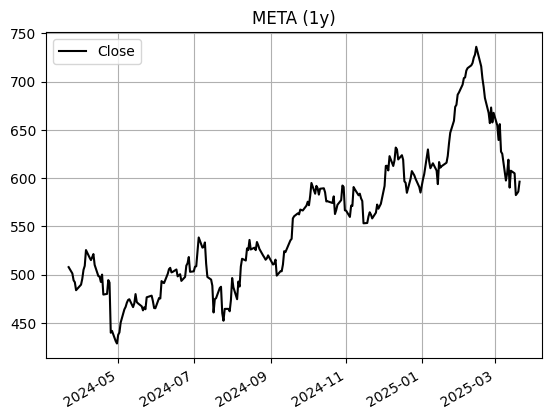

ok
👽 > ok


🙂 > quit


In [71]:
messages = [{"role":"system", "content":prompt}]
dic_tools = {'search_web':search_web, 'get_stock':get_stock}
max_i, i = 3, 0

while True:
    ## user input
    try:
        q = input('🙂 >')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    messages.append( {"role":"user", "content":q} )
    
    ## model
    agent_res = ollama.chat(model=llm, messages=messages, 
                            tools=[tool_get_stock, tool_search_web])
    try:
        dic_res = use_tool(agent_res, dic_tools)
        
    ## handle error: tool not used --> try again
    except Exception as e:
        print("⚠️ >", e)
        agent_res = ollama.chat(model=llm, messages=messages, 
                                tools=[tool_get_stock, tool_search_web])
        dic_res = use_tool(agent_res, dic_tools)

    res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
        
    ## handle error: tool used but output not good --> keep trying for x times
    while res in ['no',''] and i < max_i:
        comment = f'''I used tool '{tool_used}' with inputs {inputs_used}. But it didn't work, so I must try a different way.'''
        messages.append( {"role":"assistant", "content":comment} )
        agent_res = ollama.chat(model=llm, messages=messages,
                                tools=[tool_get_stock, tool_search_web])
        dic_res = use_tool(agent_res, dic_tools)
        res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]

        ## chain: output of previous tool = input of next tool
        if tool_used == 'search_web':
            query = q+". You must return just the compay ticker.\nContext: "+res
            llm_res = ollama.generate(model=llm, prompt=query)["response"]
            messages.append( {"role":"user", "content":f"try ticker: {llm_res}"} )
            
            print("👽 >", f"\x1b[1;30mI can try with {llm_res}\x1b[0m")
            
            agent_res = ollama.chat(model=llm, messages=messages, tools=[tool_get_stock])
            dic_res = use_tool(agent_res, dic_tools)
            res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
        
        i += 1
        if i == max_i:
            res = f'I tried {i} times but something is wrong'

    ## final response
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )

In [72]:
messages

[{'role': 'system',
  'content': "\n[GOAL] You are a financial analyst, assist the user using your available tools.\n\n[RETURN] You must return the stock data that the user asks for.\n\n[WARNINGS] In order to retrieve stock data, you need to know the ticker symbol of the company.\n\n[CONTEXT] First ALWAYS try to use the tool 'get_stock'.\nIf it doesn't work, you can use the tool 'search_web' and search 'company name stock'. \nGet information about the stock and deduct what is the right ticker symbol of the company.\nThen, you can use AGAIN the tool 'get_stock' with the ticker you got using the previous tool.\n"},
 {'role': 'user', 'content': 'hi'},
 {'role': 'assistant',
  'content': 'Hello! How can I assist you with your finances today? Do you need information on a specific stock or company?'},
 {'role': 'user', 'content': 'show me 1 year of facebook stock'},
 {'role': 'assistant',
  'content': "I used tool 'get_stock' with inputs {'col': 'Close', 'period': '1y', 'ticker': 'FB'}. But 

## ------------------------------------------
## 3 - Multi Agents
## ------------------------------------------

### 3.1. Sequential

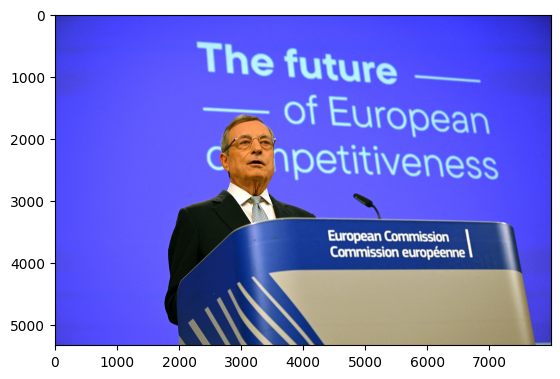

In [6]:
from matplotlib import image as pltimg, pyplot as plt

image_file = "draghi.jpeg"

plt.imshow(pltimg.imread(image_file))
plt.show()

###### Agent 1 (Vision Model)

In [21]:
res = ollama.generate(model="llava", prompt="describe the image", images=[image_file])["response"]
print(res)

 The image is a photograph of a man speaking at an event. He appears to be at a podium, standing behind a microphone and facing the audience, with his hands clasped in front of him. The man has light-colored hair, a suit jacket, and he seems to be addressing an audience.

Behind him, there is a graphic design element that includes text and an image. The text reads "THE FUTURE OF EUROPEAN COMPETITIVENESS" in capital letters. Below this title, there is the logo of European Commission, which features the flag of the European Union at its center.

The backdrop to the event is a dark blue with some light graphics that are not clearly visible. The overall setting suggests an official or professional gathering related to the European Commission's work on competitiveness. 


In [26]:
def process_image(path:str) -> str:
    return ollama.generate(model="llava", prompt="describe the image", images=[path])["response"]

tool_process_image = {'type':'function', 'function':{
  'name': 'process_image',
  'description': 'Load an image for a given path and describe what you see',
  'parameters': {'type': 'object', 
                 'required': ['path'],
                 'properties': {
                    'path': {'type':'str', 'description':'the path of the image'},
}}}}
## test
process_image(path=image_file)

' The image is a photograph of an individual standing at a podium. The person appears to be a male, dressed in formal attire with a dark suit and tie, and he has gray hair. He is addressing an audience and seems to be speaking at an event or meeting, as indicated by the setting which includes a stage and a backdrop with text.\n\nThe backdrop prominently displays a message that reads "THE FUTURE OF EUROPEAN COMPETITIVENESS," suggesting that the event is related to the discussion of economic strategies in Europe. Below this main text, there\'s another line of smaller text which appears to be a slogan or motto for the event, but it\'s not fully visible due to the angle and cropping of the photo.\n\nThe person on the podium has his hands slightly raised, possibly indicating the middle of a speech or presentation. The lighting in the photograph is bright, illuminating the speaker well against the darker background. There is also a logo of the European Commission with the French phrase "Comm

In [ ]:
prompt = '''
You are a photographer that analyzes and describes images in details.
''' 
messages_1 = [{"role":"system", "content":prompt}]

###### Agent 2 (Wikipedia)

In [27]:
#pip install wikipedia==1.4.0
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

def search_wikipedia(query:str) -> str:
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(query)

tool_search_wikipedia = {'type':'function', 'function':{
  'name': 'search_wikipedia',
  'description': 'Search on Wikipedia by passing some keywords',
  'parameters': {'type': 'object', 
                 'required': ['query'],
                 'properties': {
                    'query': {'type':'str', 'description':'The input must be short keywords, not a long text'},
}}}}
## test
search_wikipedia(query="draghi")

/Users/mdp/opt/anaconda3/envs/GENAI2/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/mdp/opt/anaconda3/envs/GENAI2/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Page: Mario Draghi\nSummary: Mario Draghi  (Italian: [ˈmaːrjo ˈdraːɡi]; born 3 September 1947) is an Italian politician, economist, academic, banker, statesman, and civil servant, who served as the prime minister of Italy from 13 February 2021 to 22 October 2022. Prior to his appointment as prime minister, he served as the president of the European Central Bank (ECB) between 2011 and 2019. Draghi was also the chair of the Financial Stability Board between 2009 and 2011, and governor of the Bank of Italy between 2006 and 2011.\nAfter a lengthy career as an academic economist in Italy, Draghi worked for the World Bank in Washington, D.C., throughout the 1980s, and in 1991 returned to Rome to become director general of the Italian Treasury. He left that role after a decade to join Goldman Sachs, where he remained until his appointment as governor of the Bank of Italy in 2006. His tenure as Governor coincided with the 2008 Great Recession, and in the midst of this he was selected to becom

In [ ]:
prompt = '''
You are a detective. You read the image description provided by the photographer, 
and you search Wikipedia to understand when and where the picture was taken.
''' 
messages_2 = [{"role":"system", "content":prompt}]

###### Pipeline

In [ ]:
dic_tools = {'process_image':process_image, 'search_wikipedia':search_wikipedia}

📷 > give me the image to analyze: draghi.jpeg


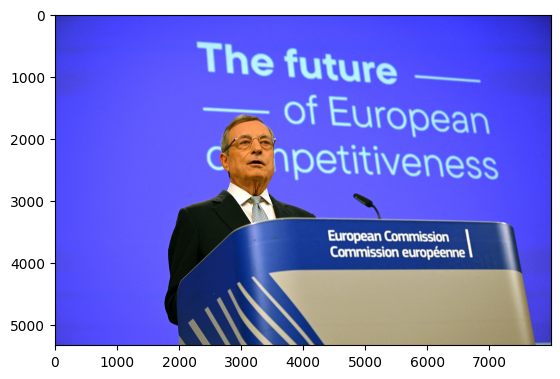

🔧 > process_image -> Inputs: {'path': 'draghi.jpeg'}
 The image is a photograph of an individual who appears to be at a speaking event. The person, who could be a politician or speaker, is standing in front of a microphone and a podium with a logo that includes "European Commission" and text that reads "The Future of European Competitiveness". The person is dressed formally, wearing a dark suit and tie. They are holding what seems to be notes in their right hand. In the background, there is a flag on the left side, but it's not clear which country it represents due to the angle and distance from the flag. The overall setting suggests a formal or official event related to European policy or economic discussion. 
👽📷 >  The image is a photograph of an individual who appears to be at a speaking event. The person, who could be a politician or speaker, is standing in front of a microphone and a podium with a logo that includes "European Commission" and text that reads "The Future of European

In [48]:
while True:
    ## user input
    try:
        q = input('📷 > give me the image to analyze:')
    except EOFError:
        break
    if q == "quit":
        break
    if q.strip() == "":
        continue
    messages_1.append( {"role":"user", "content":q} )

    plt.imshow(pltimg.imread(q))
    plt.show()
    
    ## Agent 1
    agent_res = ollama.chat(model=llm, tools=[tool_process_image], messages=messages_1)
    dic_res = use_tool(agent_res, dic_tools)
    res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]

    print("👽📷 >", f"\x1b[1;30m{res}\x1b[0m")
    messages_1.append( {"role":"assistant", "content":res} )

    ## Agent 2
    messages_2.append( {"role":"system", "content":"-Picture: "+res} )

    agent_res = ollama.chat(model=llm, tools=[tool_search_wikipedia], messages=messages_2)
    dic_res = use_tool(agent_res, dic_tools)
    res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
    
    if tool_used == "search_wikipedia":
        messages_2.append( {"role":"system", "content":"-Wikipedia: "+res} )
        agent_res = ollama.chat(model=llm, tools=[], messages=messages_2)
        dic_res = use_tool(agent_res, dic_tools)
        res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
    else:
        messages_2.append( {"role":"assistant", "content":res} )
    
    print("👽📖 >", f"\x1b[1;30m{res}\x1b[0m")
    break

### 3.2. Hierarchical

In [73]:
import pandas as pd

dtf = pd.read_csv('http://bit.ly/kaggletrain')
dtf.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [74]:
## Create db
import sqlite3

dtf.to_sql(index=False, name="titanic", con=sqlite3.connect("database.db"), if_exists="replace")

891

In [77]:
## Connect db
from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///database.db")

###### Agent Junior

In [107]:
from langchain_community.tools.sql_database.tool import ListSQLDatabaseTool

def get_tables() -> str:
    return ListSQLDatabaseTool(db=db).invoke("")

tool_get_tables = {'type':'function', 'function':{
  'name': 'get_tables',
  'description': 'Returns the name of the tables in the database.',
  'parameters': {'type': 'object', 
                 'required': [],
                 'properties': {}
}}}
## test
get_tables()

'titanic'

In [137]:
from langchain_community.tools.sql_database.tool import InfoSQLDatabaseTool

def get_schema(tables: str) -> str:
    tool = InfoSQLDatabaseTool(db=db)
    return tool.invoke(tables)

tool_get_schema = {'type':'function', 'function':{
  'name': 'get_schema',
  'description': 'Returns the name of the columns in the table.',
  'parameters': {'type': 'object', 
                 'required': ['tables'],
                 'properties': {'tables': {'type':'str', 'description':'table name. Example Input: table1, table2, table3'}}
}}}
## test
get_schema(tables='titanic')

'\nCREATE TABLE titanic (\n\t"PassengerId" INTEGER, \n\t"Survived" INTEGER, \n\t"Pclass" INTEGER, \n\t"Name" TEXT, \n\t"Sex" TEXT, \n\t"Age" REAL, \n\t"SibSp" INTEGER, \n\t"Parch" INTEGER, \n\t"Ticket" TEXT, \n\t"Fare" REAL, \n\t"Cabin" TEXT, \n\t"Embarked" TEXT\n)\n\n/*\n3 rows from titanic table:\nPassengerId\tSurvived\tPclass\tName\tSex\tAge\tSibSp\tParch\tTicket\tFare\tCabin\tEmbarked\n1\t0\t3\tBraund, Mr. Owen Harris\tmale\t22.0\t1\t0\tA/5 21171\t7.25\tNone\tS\n2\t1\t1\tCumings, Mrs. John Bradley (Florence Briggs Thayer)\tfemale\t38.0\t1\t0\tPC 17599\t71.2833\tC85\tC\n3\t1\t3\tHeikkinen, Miss. Laina\tfemale\t26.0\t0\t0\tSTON/O2. 3101282\t7.925\tNone\tS\n*/'

In [134]:
prompt_junior = '''
[GOAL] You are a data engineer who builds efficient SQL queries to get data from the database.

[RETURN] You must return a final SQL query based on user's instructions.

[WARNINGS] Use your tools only once.

[CONTEXT] In order to generate the perfect SQL query, you need to know the name of the table and the schema.
First ALWAYS use the tool 'get_tables' to find the name of the table.
Then, you MUST use the tool 'get_schema' to get the columns in the table.
Finally, based on the information you got, generate an SQL query to answer user question. 
'''

###### Agent Senior

In [81]:
#from langchain_community.tools.sql_database.tool import QuerySQLCheckerTool
#def sql_check(sql: str) -> str:
#    return QuerySQLCheckerTool(db=db, llm=llm).invoke({"query":sql})

def sql_check(sql: str) -> str:
    p = f'''Double check if the SQL query is correct: {sql}. You MUST just SQL code without comments'''
    res = ollama.generate(model=llm, prompt=p)["response"]
    return res.replace('sql','').replace('```','').replace('\n',' ').strip()

tool_sql_check = {'type':'function', 'function':{
  'name': 'sql_check',
  'description': 'Before executing a query, always review the SQL query and correct the code if necessary',
  'parameters': {'type': 'object', 
                 'required': ['sql'],
                 'properties': {'sql': {'type':'str', 'description':'SQL code'}}
}}}
## test
sql_check(sql='SELECT * FROM titanic TOP 3')

'SELECT * FROM titanic LIMIT 3;'

In [143]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def sql_exec(sql: str) -> str:
    return QuerySQLDataBaseTool(db=db).invoke(sql)
    
tool_sql_exec = {'type':'function', 'function':{
  'name': 'sql_exec',
  'description': 'Execute a SQL query',
  'parameters': {'type': 'object', 
                 'required': ['sql'],
                 'properties': {'sql': {'type':'str', 'description':'SQL code'}}
}}}
## test
sql_exec(sql='SELECT * FROM titanic LIMIT 3')

"[(1, 0, 3, 'Braund, Mr. Owen Harris', 'male', 22.0, 1, 0, 'A/5 21171', 7.25, None, 'S'), (2, 1, 1, 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'female', 38.0, 1, 0, 'PC 17599', 71.2833, 'C85', 'C'), (3, 1, 3, 'Heikkinen, Miss. Laina', 'female', 26.0, 0, 0, 'STON/O2. 3101282', 7.925, None, 'S')]"

In [105]:
prompt_senior = '''
[GOAL] You are a senior data engineer who reviews and execute the SQL queries written by others.

[RETURN] You must return data from the database.

[WARNINGS] Use your tools only once.

[CONTEXT] ALWAYS check the SQL code before executing on the database.
First ALWAYS use the tool 'sql_check' to review the query. The output of this tool is the correct SQL query.
You MUST use ONLY the correct SQL query when you use the tool 'sql_exec'.
'''

###### Agent Lead

In [86]:
def invoke_agent(agent:str, instructions:str) -> str:
    return agent+" - "+instructions if agent in ['junior','senior'] else f"Agent '{agent}' Not Found"
    
tool_invoke_agent = {'type':'function', 'function':{
  'name': 'invoke_agent',
  'description': 'Invoke another Agent to work for you.',
  'parameters': {'type': 'object', 
                 'required': ['agent', 'instructions'],
                 'properties': {
                     'agent': {'type':'str', 'description':'the Agent name, one of "junior" or "senior".'},
                     'instructions': {'type':'str', 'description':'detailed instructions for the Agent.'}
                 }
}}}
## test
invoke_agent(agent="intern", instructions="build a query")

"Agent 'intern' Not Found"

In [94]:
prompt_lead = '''
[GOAL] You are a tech lead. 
You have a team with one junior data engineer called 'junior', and one senior data engineer called 'senior'.

[RETURN] You must return data from the database based on user's requests.

[WARNINGS] You are the only one that talks to the user and gets the requests from the user.
The 'junior' data engineer only builds queries.
The 'senior' data engineer checks the queries and execute them. 

[CONTEXT] First ALWAYS ask the users what they want.
Then, you MUST use the tool 'invoke_agent' to pass the instructions to the 'junior' for building the query.
Finally, you MUST use the tool 'invoke_agent' to pass the instructions to the 'senior' for retrieving the data from the database.
'''

###### Workflow

In [138]:
dic_tools = {'get_tables':get_tables, 
             'get_schema':get_schema, 
             'sql_exec':sql_exec, 
             'sql_check':sql_check, 
             'invoke_agent':invoke_agent}

In [142]:
messages_junior = [{"role":"system", "content":prompt_junior}]
messages_senior = [{"role":"system", "content":prompt_senior}]
messages_lead   = [{"role":"system", "content":prompt_lead}]

while True:
    ## user input
    q = input('🙂 >')
    if q == "quit":
        break
    messages_lead.append( {"role":"user", "content":q} )
    
    ## Lead Agent
    agent_res = ollama.chat(model=llm, messages=messages_lead, tools=[tool_invoke_agent])
    dic_res = use_tool(agent_res, dic_tools)
    res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
    agent_invoked = res.split("-")[0].strip() if len(res.split("-")) > 1 else ''
    instructions = res.split("-")[1].strip() if len(res.split("-")) > 1 else ''

    ## Invoke Junior Agent
    if agent_invoked == "junior":
        print("😎 >", f"\x1b[1;32mReceived instructions: {instructions}\x1b[0m")
        messages_junior.append( {"role":"user", "content":instructions} )
        
        ### use the tools
        available_tools = {"get_tables":tool_get_tables, "get_schema":tool_get_schema}
        context = ''
        while available_tools:
            agent_res = ollama.chat(model=llm, messages=messages_junior, 
                                    tools=[v for v in available_tools.values()])
            dic_res = use_tool(agent_res, dic_tools)
            res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
            if tool_used:
                available_tools.pop(tool_used)
            context = context + f"\nTool used: {tool_used}. Output: {res}" #->add tool usage context
            messages_junior.append( {"role":"user", "content":context} )
            
        ### response
        agent_res = ollama.chat(model=llm, messages=messages_junior)
        dic_res = use_tool(agent_res, dic_tools)
        res = dic_res["res"]
        print("😎 >", f"\x1b[1;32m{res}\x1b[0m")
        messages_junior.append( {"role":"assistant", "content":res} )

        ## update Lead Agent
        context = "Junior already wrote this query: "+res+ "\nNow invoke the Senior to review and execute the code."
        print("👩‍💼 >", f"\x1b[1;30m{context}\x1b[0m")
        messages_lead.append( {"role":"user", "content":context} )
        agent_res = ollama.chat(model=llm, messages=messages_lead, tools=[tool_invoke_agent])
        dic_res = use_tool(agent_res, dic_tools)
        res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
        agent_invoked = res.split("-")[0].strip() if len(res.split("-")) > 1 else ''
        instructions = res.split("-")[1].strip() if len(res.split("-")) > 1 else ''
    
    ## Invoke Senior Agent
    if agent_invoked == "senior":
        print("🥸 >", f"\x1b[1;34mReceived instructions: {instructions}\x1b[0m")
        messages_senior.append( {"role":"user", "content":instructions} )
        
        ### use the tools
        available_tools = {"sql_check":tool_sql_check, "sql_exec":tool_sql_exec}
        context = ''
        while available_tools:
            agent_res = ollama.chat(model=llm, messages=messages_senior, 
                                    tools=[v for v in available_tools.values()])
            dic_res = use_tool(agent_res, dic_tools)
            res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
            if tool_used:
                available_tools.pop(tool_used)
            context = context + f"\nTool used: {tool_used}. Output: {res}" #->add tool usage context 
            messages_senior.append( {"role":"user", "content":context} )
            
        ### response
        print("🥸 >", f"\x1b[1;34m{res}\x1b[0m")
        messages_senior.append( {"role":"assistant", "content":res} )
        
        ### update Lead Agent
        context = "Senior agent returned this output: "+res
        print("👩‍💼 >", f"\x1b[1;30m{context}\x1b[0m")
        messages_lead.append( {"role":"user", "content":context} )
    
    ## Lead Agent final response
    print("👩‍💼 >", f"\x1b[1;30m{res}\x1b[0m")
    messages_lead.append( {"role":"assistant", "content":res} )

🙂 > hi


👩‍💼 > Hello! How can I assist you today? Do you need data retrieved from the database based on some specific requests?


🙂 > how many women are in the db?


🔧 > invoke_agent -> Inputs: {'agent': 'junior', 'instructions': 'Create a query to count the number of female records in the database.'}
junior - Create a query to count the number of female records in the database.
😎 > Received instructions: Create a query to count the number of female records in the database.
🔧 > get_tables -> Inputs: {}
titanic
🔧 > get_schema -> Inputs: {'tables': 'titanic'}

CREATE TABLE titanic (
	"PassengerId" INTEGER, 
	"Survived" INTEGER, 
	"Pclass" INTEGER, 
	"Name" TEXT, 
	"Sex" TEXT, 
	"Age" REAL, 
	"SibSp" INTEGER, 
	"Parch" INTEGER, 
	"Ticket" TEXT, 
	"Fare" REAL, 
	"Cabin" TEXT, 
	"Embarked" TEXT
)

/*
3 rows from titanic table:
PassengerId	Survived	Pclass	Name	Sex	Age	SibSp	Parch	Ticket	Fare	Cabin	Embarked
1	0	3	Braund, Mr. Owen Harris	male	22.0	1	0	A/5 21171	7.25	None	S
2	1	1	Cumings, Mrs. John Bradley (Florence Briggs Thayer)	female	38.0	1	0	PC 17599	71.2833	C85	C
3	1	3	Heikkinen, Miss. Laina	female	26.0	0	0	STON/O2. 3101282	7.925	None	S
*/
😎 > Based o

🙂 > quit


###### Final Answer as a Tool

In [2]:
def final_answer(text:str) -> str:
    return text

tool_final_answer = {'type':'function', 'function':{
  'name': 'final_answer',
  'description': 'Returns a natural language response to the user',
  'parameters': {'type': 'object', 
                 'required': ['text'],
                 'properties': {'text': {'type':'str', 'description':'natural language response'}}
}}}
## test
final_answer(text="hi")

'hi'

###### Other Tools

In [3]:
## WebSearch
from langchain_community.tools import DuckDuckGoSearchResults 

def search_web(query:str) -> str:
  return DuckDuckGoSearchResults(backend="news").run(query)

tool_search_web = {'type':'function', 'function':{
  'name': 'search_web',
  'description': 'Search the web',
  'parameters': {'type': 'object', 
                 'required': ['query'],
                 'properties': {
                    'query': {'type':'str', 'description':'the topic or subject to search on the web'},
}}}}
## test
search_web(query="nvidia")

'snippet: Nvidia announced on Monday that it plans to "build and test NVIDIA Blackwell chips in Arizona and AI supercomputers in Texas.", title: Nvidia leans further into US manufacturing as Trump promises chip tariffs down the road, link: https://www.msn.com/en-us/news/other/nvidia-leans-further-into-us-manufacturing-as-trump-promises-chip-tariffs-down-the-road/ar-AA1CTOsg, date: 2025-04-14T15:37:19+00:00, source: Insider, snippet: Nvidia says it has commissioned space to build AI chips in Arizona and Texas as part of an effort to move a portion of production to the U.S., title: Nvidia says it plans to manufacture some AI chips in the US, link: https://www.msn.com/en-us/news/technology/nvidia-says-it-plans-to-manufacture-some-ai-chips-in-the-us/ar-AA1CTcdz, date: 2025-04-14T15:21:00+00:00, source: TechCrunch, snippet: Nvidia announced Monday that it will produce its artificial intelligence super computers in the United States for the first time., title: Nvidia plans to manufacture AI 

In [4]:
## Coding
import io
import contextlib

def code_exec(code:str) -> str:
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        try:
            exec(code)
        except Exception as e:
            print(f"Error: {e}")
    return output.getvalue()

tool_code_exec = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'Execute python code. Use always the function print() to get the output.',
  'parameters': {'type': 'object', 
                 'required': ['code'],
                 'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

code_exec("from datetime import datetime; print(datetime.now().strftime('%H:%M'))")

'19:33\n'

###### Prompt

In [5]:
dic_tools = {'final_answer':final_answer,
             'search_web':search_web, 
             'code_exec':code_exec}

In [227]:
prompt = '''
[GOAL] You are an intelligent assistant, provide the best possible answer to user's request.

[RETURN] As the last step, you MUST use the tool 'final_answer' to return the final output.

[WARNINGS] You can use each tool only once.

[CONTEXT] You can search for any information in the web using the tool 'search_web'.
You can generate Python code and execute it with the tool 'code_exec'.
When you have enough information to answer the user's request, you can return the final answer with the tool 'final_answer'.
'''

In [12]:
prompt = '''
You will be given a task to solve as best you can.
You have access to the following tools:
'code_exec' to execute python code.
'search_web' to search the internet for information.

To solve the task, you must plan forward to proceed in a series of steps, in a cycle of 'Thought:', 'Action:', and 'Observation:' sequences.
At each step, in the 'Thought:' sequence, you should first explain your reasoning towards solving the task, then the tools that you want to use.
Then in the 'Action:' sequence, you shold use one of your tools.
During each intermediate step, you can use 'Observation:' field to save whatever important information you will use as input for the next step.

In the end you have to return a final answer using the 'final_answer' tool.
If the user doesn't ask any question, you must directly use the 'final_answer' tool.
'''

###### 4. Structure

In [13]:
def use_tool(agent_res:dict, dic_tools:dict) -> dict:
    ## use tool
    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                print(t_output)
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
    ## don't use tool
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
        t_name, t_inputs = '', ''
    return {'res':res, 'tool_used':t_name, 'inputs_used':t_inputs}

###### 5. Workflow

In [14]:
messages = [{"role":"system", "content":prompt}]

while True:
    ## User
    q = input('🙂 >')
    if q == "quit":
        break
    if q.strip() == "":
        continue
    messages.append( {"role":"user", "content":q} )
    
    ## Model
    available_tools = {"final_answer":tool_final_answer, "search_web":tool_search_web, "code_exec":tool_code_exec}
    tool_used, memory = '', ''
    while tool_used != 'final_answer':
        ### use tools
        try:
            agent_res = ollama.chat(model=llm, messages=messages, 
                                    tools=[v for v in available_tools.values()])
            dic_res = use_tool(agent_res, dic_tools)
            res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
        ### error
        except Exception as e:
            print("⚠️ >", e)
            res = f"I tried to use {tool_used} but didn't work. I will try something else."
            print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
            messages.append( {"role":"assistant", "content":res} )
        ### update memory
        if tool_used not in ['','final_answer']:
            memory += f"\nTool used: {tool_used}.\nInput used: {inputs_used}.\nOutput: {res}"
            messages.append( {"role":"assistant", "content":memory} )
            available_tools.pop(tool_used)
            if len(available_tools) == 1:
                messages.append( {"role":"user", "content":"now activate the tool final_answer."} )
        ### tools not used
        if tool_used == '':
            break
    
    ## Response
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )

🙂 > hi


👽 > Thought: The user has sent a simple greeting. I should respond in kind.
Action: final_answer
ombok
{"text": "Hello there!"}


KeyboardInterrupt: Interrupted by user

In [217]:
messages

[{'role': 'system',
  'content': "\n[GOAL] You are an intelligent assistant, provide the best possible answer to user's request.\n\n[RETURN] As the last step, you MUST use the tool 'final_answer' to return the final output.\n\n[WARNINGS] Use all the available tools to collect information, before giving the final answer.\n\n[CONTEXT] You can search for any information in the web using the tool 'search_web'.\nYou can generate Python code and execute it with the tool 'code_exec'.\nWhen you have enough information to answer the user's request, you can return the final answer with the tool 'final_answer'.\n"},
 {'role': 'user', 'content': 'what time is it now?'},
 {'role': 'assistant',
  'content': 'The current time is not directly provided by me, but you can check your device for the accurate time. If you need help with anything else, feel free to ask!'},
 {'role': 'user', 'content': 'use your tools and answer me'},
 {'role': 'assistant',
  'content': "\nTool used: search_web.\nInput used:

###### SQL Agent

In [145]:
from langchain_community.utilities.sql_database import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///database.db")

In [146]:
from langchain_community.tools.sql_database.tool import ListSQLDatabaseTool, InfoSQLDatabaseTool, QuerySQLDataBaseTool

def get_tables() -> str:
    return ListSQLDatabaseTool(db=db).invoke("")

tool_get_tables = {'type':'function', 'function':{
  'name': 'get_tables',
  'description': 'Returns the name of the tables in the database.',
  'parameters': {'type': 'object', 
                 'required': [],
                 'properties': {}
}}}

def get_schema(tables: str) -> str:
    tool = InfoSQLDatabaseTool(db=db)
    return tool.invoke(tables)

tool_get_schema = {'type':'function', 'function':{
  'name': 'get_schema',
  'description': 'Returns the name of the columns in the table.',
  'parameters': {'type': 'object', 
                 'required': ['tables'],
                 'properties': {'tables': {'type':'str', 'description':'table name. Example Input: table1, table2, table3'}}
}}}

def sql_exec(sql: str) -> str:
    return QuerySQLDataBaseTool(db=db).invoke(sql)
    
tool_sql_exec = {'type':'function', 'function':{
  'name': 'sql_exec',
  'description': 'Execute a SQL query',
  'parameters': {'type': 'object', 
                 'required': ['sql'],
                 'properties': {'sql': {'type':'str', 'description':'SQL code'}}
}}}

def sql_check(sql: str) -> str:
    p = f'''Double check if the SQL query is correct: {sql}. You MUST just SQL code without comments'''
    res = ollama.generate(model=llm, prompt=p)["response"]
    return res.replace('sql','').replace('```','').replace('\n',' ').strip()

tool_sql_check = {'type':'function', 'function':{
  'name': 'sql_check',
  'description': 'Before executing a query, always review the SQL query and correct the code if necessary',
  'parameters': {'type': 'object', 
                 'required': ['sql'],
                 'properties': {'sql': {'type':'str', 'description':'SQL code'}}
}}}

In [147]:
def final_answer(text:str) -> str:
    return text

tool_final_answer = {'type':'function', 'function':{
  'name': 'final_answer',
  'description': 'Returns a natural language response to the user',
  'parameters': {'type': 'object', 
                 'required': ['text'],
                 'properties': {'text': {'type':'str', 'description':'natural language response'}}
}}}
## test
final_answer(text="hi")

'hi'

In [ ]:
prompt_sql = '''
[GOAL] You are an expert Data Engineer, retrieve data from the database using SQL based on user's requests.
You must answer every question from the user, you can use the list of tools provided to you.
After you finish your job, use the 'final_answer' tool to answer the user.

[RETURN] You must return data extracted from the database.

[WARNINGS] In order to generate the perfect SQL query, you need to know the name of the table and the schema.
Remember to ALWAYS check the SQL code before executing on the database.
Don't use any tool with the same query more than once.

[CONTEXT] First ALWAYS use the tool 'get_tables' to find the name of the table.
Then, you MUST use the tool 'get_schema' to get the columns in the table.
Then, based on the information you got, generate an SQL query to answer user question. 
Then, use the tool 'sql_check' to review the query. The output of this tool is the correct SQL query.
Finally, you MUST use ONLY the correct SQL query when you use the tool 'sql_exec'.
'''

###### Python Agent

In [ ]:
import io
import contextlib

def code_exec(code:str) -> str:
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        try:
            exec(code)
        except Exception as e:
            print(f"Error: {e}")
    return output.getvalue()

tool_code_exec = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'Execute python code. Use always the function print() to get the output.',
  'parameters': {'type': 'object', 
                 'required': ['code'],
                 'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

code_exec("from datetime import datetime; print(datetime.now().strftime('%H:%M'))")

In [ ]:
prompt_py = '''
[GOAL] You are an expert Data Analyst, you write Python code to analyze data.
You must answer every question from the user, you can use the list of tools provided to you.
After you finish your job, use the 'final_answer' tool to answer the user.

[RETURN] You must generate and execute Python code to create plots.

[WARNINGS] ALWAYS execute the following code exactly as it is: 'df=pd.read_csv(path); print(df.head())'.
If you create a plot, ALWAYS add 'plt.show()' at the end.

[CONTEXT] Start by loading the data.
'''

###### ML Agent

In [ ]:
def train_model(code:str) -> str:
   
    return

tool_train_model = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'Execute python code. Use always the function print() to get the output.',
  'parameters': {'type': 'object', 
                 'required': ['code'],
                 'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

train_model("from datetime import datetime; print(datetime.now().strftime('%H:%M'))")

In [ ]:
def save_model(code:str) -> str:
   
    return

tool_save_model = {'type':'function', 'function':{
  'name': 'code_exec',
  'description': 'Execute python code. Use always the function print() to get the output.',
  'parameters': {'type': 'object', 
                 'required': ['code'],
                 'properties': {
                    'code': {'type':'str', 'description':'code to execute'},
}}}}

save_model("from datetime import datetime; print(datetime.now().strftime('%H:%M'))")

In [ ]:
prompt_ml = '''
[GOAL] You are an expert Data Scientist, you train machine learning models.
You must answer every question from the user, you can use the list of tools provided to you.
After you finish your job, use the 'final_answer' tool to answer the user.

[RETURN] The final output must be a model object saved on the computer.

[WARNINGS] 

[CONTEXT] You must answer every question from the user, you can use the list of tools provided to you.
Once you have collected plenty of information to answer the user's question use the 'final_answer' tool.
If the user doesn't ask a specific question, you MUST use the 'final_answer' tool directly.
'''

In [ ]:
dic_tools = {'final_answer':final_answer,
             'get_tables':get_tables, 
             'get_schema':get_schema, 
             'sql_exec':sql_exec, 
             'sql_check':sql_check,
             'code_exec':code_exec,
             'train_model':train_model,
             'save_model':save_model}

###### Utils functions

In [ ]:
def use_tool(agent_res:dict, dic_tools:dict) -> dict:
    ## use tool
    if "tool_calls" in agent_res["message"].keys():
        for tool in agent_res["message"]["tool_calls"]:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                print(t_output)
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")
    ## don't use tool
    if agent_res['message']['content'] != '':
        res = agent_res["message"]["content"]
        t_name, t_inputs = '', ''
    return {'res':res, 'tool_used':t_name, 'inputs_used':t_inputs}

###### Workflow

In [ ]:
messages_sql = [{"role":"system", "content":prompt_sql}]
messages_py  = [{"role":"system", "content":prompt_py}]
messages_ml  = [{"role":"system", "content":prompt_ml}]
shared_memory = ''

while True:    
    ## User
    q = input('🙂 >')
    if q == "quit":
        break
    
    messages_sql.append( {"role":"user", "content":q} )
    
    ## Model
    available_tools = {"final_answer":tool_final_answer, 
                       "get_tables":tool_get_tables, "get_schema":tool_get_schema,
                       "sql_exec":tool_sql_exec, "sql_check":sql_check}
    tool_used, memory = '', ''
    while tool_used != 'final_answer':
        ### use tools
        try:
            agent_res = ollama.chat(model=llm, messages=messages_sql, 
                                    tools=[v for v in available_tools.values()])
            dic_res = use_tool(agent_res, dic_tools)
            res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]
        ### error
        except Exception as e:
            print("⚠️ >", e)
            res = f"I tried to use {tool_used} but didn't work. I will try something else."
            print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
            messages.append( {"role":"assistant", "content":res} )
        ### update memory
        if tool_used not in ['','final_answer']:
            memory += f"\nTool used: {tool_used}.\nInput used: {inputs_used}.\nOutput: {res}"
            messages.append( {"role":"assistant", "content":memory} )
            available_tools.pop(tool_used)
            if len(available_tools) == 1:
                messages.append( {"role":"user", "content":"now activate the tool final_answer."} )
        ### tools not used
        if tool_used == '':
            break
    
    ## Response
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )